In [1]:
from rouge_score.rouge_scorer import _create_ngrams
from nltk.stem.porter import PorterStemmer
import json
import six
from utils import tokenize
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import os
from tqdm import tqdm
import time

start_time = time.time()
METHOD = "SVM"
DATA = "Reddit_Minimum_100"
PATH = "./regenerated/results_reddit_min100.json"

#! N-Gram Score Generation
def get_score_ngrams(target_ngrams, prediction_ngrams):
    intersection_ngrams_count = 0
    ngram_dict = {}
    for ngram in six.iterkeys(target_ngrams):
        intersection_ngrams_count += min(target_ngrams[ngram],
                                        prediction_ngrams[ngram])
        ngram_dict[ngram] = min(target_ngrams[ngram], prediction_ngrams[ngram])
    target_ngrams_count = sum(target_ngrams.values()) # prediction_ngrams
    return intersection_ngrams_count / max(target_ngrams_count, 1), ngram_dict


def get_ngram_info(article_tokens, summary_tokens, _ngram):
    article_ngram = _create_ngrams( article_tokens , _ngram)
    summary_ngram = _create_ngrams( summary_tokens , _ngram)
    ngram_score, ngram_dict = get_score_ngrams( article_ngram, summary_ngram) 
    return ngram_score, ngram_dict, sum( ngram_dict.values() )

print("Loading Data...")
#! Load Data from file
data = None
with open(PATH, "r") as f:
    data = json.load(f)
print(f"{len(data)} generated texts loaded.")

Loading Data...
2500 generated texts loaded.


In [2]:
#! Calculate n-grams
ngram_overlap_count_wq = []
for idx in tqdm(range(len(data))):
    # tokenization
    cur = data[idx]
    masked_original = cur["masked_original"]
    human_tokenized = tokenize(masked_original, stemmer=PorterStemmer())
    generated = cur["masked_generated"]
    if generated == None: continue

    # going through each generation
    temp = []
    for j in range(len(generated)):
        tempp = {} # storing all the ngram scores
        generated_tokenized = tokenize(generated[j], stemmer=PorterStemmer())
        if len(human_tokenized) == 0 or len(generated_tokenized) == 0:
            continue
        
        # go through each possible n gram from 1 to 25
        for _ngram in range(1, 25):
            ngram_score, ngram_dict, overlap_count = get_ngram_info(human_tokenized, generated_tokenized, _ngram)
            if cur["type"] == "human":
                tempp['human_truncate_ngram_{}_score'.format(_ngram)] = ngram_score / len(generated_tokenized)
            else:
                tempp['gpt_truncate_ngram_{}_score'.format(_ngram)] = ngram_score / len(generated_tokenized)
        temp.append({'type':cur["type"], 'ngrams': tempp})

    ngram_overlap_count_wq.append(temp)

100%|██████████| 2500/2500 [04:17<00:00,  9.71it/s]


In [3]:
#! Train an SVM on the data we have gathered
from sklearn import svm
TEST_TRAIN_RATIO = 0.4

# Parse Data
ngram_shuffled = np.random.permutation(ngram_overlap_count_wq)

X = []
Y = []
for idx in tqdm(range(len(ngram_shuffled))):
	cur = ngram_shuffled[idx]
	if len(cur) == 0: continue
	if cur[0]['type'] == 'human':
		Y.append(0)
	else:
		Y.append(1)

	# find the average
	to_add_x = [0] * 25
	num = 0
	for instance in cur:
		if instance == None: continue
		for idx in instance["ngrams"].keys():
			new_idx = int(idx.replace("human_truncate_ngram_", "").replace("gpt_truncate_ngram_", "").replace("_score", "")) - 1
			to_add_x[new_idx] += instance["ngrams"][idx]
		num += 1
	to_add_x = [x/num for x in to_add_x]
	X.append(to_add_x)

# Split into train and test
X_train = X[:int(len(X)*TEST_TRAIN_RATIO)]
Y_train = Y[:int(len(Y)*TEST_TRAIN_RATIO)]
X_test = X[int(len(X)*TEST_TRAIN_RATIO):]
Y_test = Y[int(len(Y)*TEST_TRAIN_RATIO):]

# Train SVM
clf = svm.SVC(random_state=1, C=17.5, tol=0.8, max_iter=744)
clf.fit(X_train, Y_train)

# Predict Results
Y_pred = clf.predict(X_test)

# Split results into human and ai
human_scores = []
ai_scores = []
for idx in range(len(Y_pred)):
	if Y_test[idx] == 0:
		human_scores.append(Y_pred[idx])
	else:
		ai_scores.append(Y_pred[idx])

print("Accuracy:", sum(Y_pred == Y_test)/len(Y_test))

/home/ajunray/anaconda3/envs/env3/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
100%|██████████| 2478/2478 [00:00<00:00, 3891.82it/s]


Accuracy: 0.7162071284465367


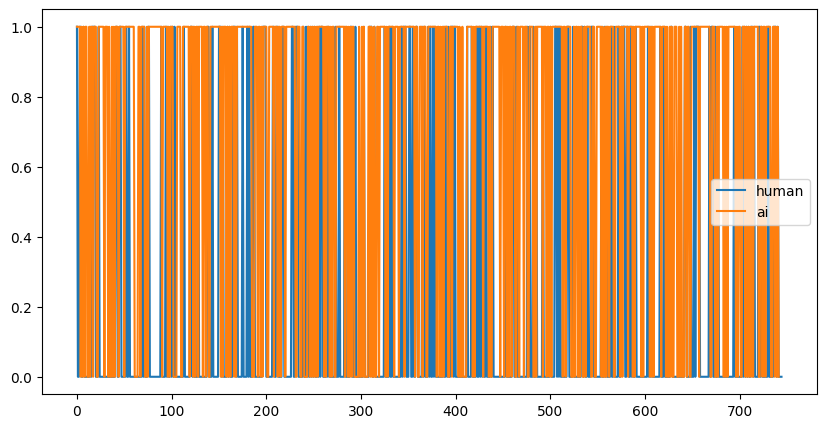

In [4]:
#! Plot Results
plt.figure(figsize=(10, 5))
plt.plot(human_scores, label='human')
plt.plot(ai_scores, label='ai')
plt.legend()
plt.show()

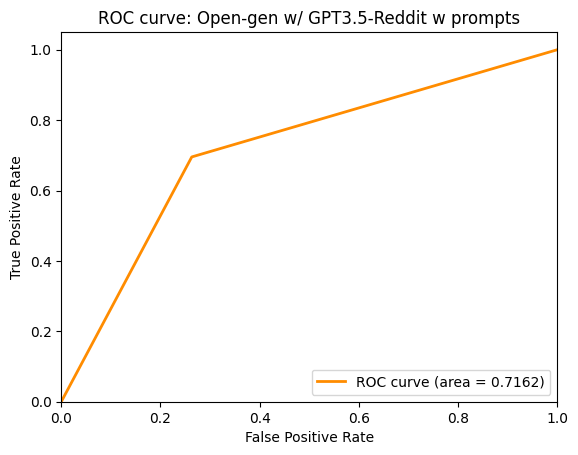

TPR at 1% FPR: 0.026432972110677157


In [5]:
#! ROC Curve Plotting
def plot_roc_curve(human_scores, gpt_scores):
    # Data
    A = human_scores
    B = gpt_scores
    # Combine scores and true labels
    scores = A + B
    labels = [0] * len(A) + [1] * len(B)
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(labels, scores)
    # Calculate AUC (Area Under Curve)
    roc_auc = auc(fpr, tpr)
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve: Open-gen w/ GPT3.5-Reddit w prompts' )
    plt.legend(loc="lower right")
    plt.show()

    # find the closest fpr more than 1% fpr
    coords1 = (0, 0)
    for idx, fpr_ in enumerate(fpr):
        if fpr_ > 0.01:
            coords1 = (float(fpr[idx]), float(tpr[idx]))
            break
    
    coords2 = (0, 0)
    for idx, fpr_ in enumerate(reversed(fpr)):
        if fpr_ < 0.01:
            coords2 = (float(fpr[len(fpr) - idx - 1]), float(fpr[len(fpr) - idx - 1]))
            break

    # (x1, y1) and (x2, y2)
    # Gradient = (y2 - y1) / (x2 - x1)
    # y = [(y2 - y1) / (x2 - x1)] (0.01 - x2) + y2
    tpr_at_one_fpr = ((coords2[1] - coords1[1]) / (coords2[0] - coords1[0])) * (0.01 - coords2[0]) + coords2[1]
    print(f"TPR at 1% FPR: {tpr_at_one_fpr}")

plot_roc_curve(human_scores, ai_scores)

In [6]:
# Save Results
import json
import numpy as np

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.int64):
            return int(obj)

if not os.path.exists(f"./results/{DATA}"):
    os.makedirs(f"./results/{DATA}")

with open(f"./results/{DATA}/{METHOD}.json", "w+") as f:
	json.dump({"ai_scores": ai_scores, "human_scores": human_scores, "time": time.time() - start_time}, f, cls=NpEncoder)